In [1]:
#Ventral Flow and Wind Flow present (tunnel ON)
#VF always moving.
#Data presenrted in lab meeting 121219.
#Results were kind of weird bc control experiments (when WF = 0), 
#the fly did not align to the direction of motion of the VF pattern. 

In [2]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
import sys
pi = math.pi

sys.path.append("/Users/fponce/Documents/vdesert/vdesert_funcs/") 

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import import_funcs.vdesert_functions as importfuncs

In [4]:
#ledpanels

def get_idx_panels_commands(ledpanels_command):
#gets the indeces of the set pattern id command and
# the gain command
    idx_pat_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'set_pattern_id']
    idx_gain_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'send_gain_bias']
    idx_stop_command = [i for i, x in enumerate(all_ledpanels_command[i])
               if x == b'stop']
    return idx_pat_command, idx_gain_command, idx_stop_command

#alicat, wind flow

def read_in_wind_flow_parameters(alicat_devices_topic):
#read in and strip the alicat message
#returns the 
    allmsg = str(alicat_devices_topic)
    allmsg_line = allmsg.split('\\n')
    
    allmsg_split = []
    for i in allmsg_line:
        msg_split = str(i).split(':')
        allmsg_split.append(msg_split)
    
    allmsg_stripped = []
    for i in allmsg_split:
        allmsg_pairs = []
        for j in i:
            msg_stripped = str(j).strip('    ')
            allmsg_pairs.append(msg_stripped)    
        allmsg_stripped.append(allmsg_pairs)
    
    return allmsg_stripped

def get_alicat_parameters(allmsg_stripped):
    
    n = 2 #number of addresses (or devices)
    
    #getting addresses
    adresses_file = []
    alicat_seq_file = []
    rate_set_point_file = []
    rate_actual_file = []
    success_file = []
    for i in range(len(allmsg_stripped)):
        for j in range(len(allmsg_stripped[i])):
            if allmsg_stripped[i][j] == 'address':
                adresses_file.append(allmsg_stripped[i][1][1])
            elif allmsg_stripped[i][j] == 'seq':
                alicat_seq_file.append(int(allmsg_stripped[i][1]))
            elif allmsg_stripped[i][j] == 'rate_set_point':
                rate_set_point_file.append(float(allmsg_stripped[i][1]))  
            elif allmsg_stripped[i][j] == 'rate_actual':
                rate_actual_file.append(float(allmsg_stripped[i][1]))   
            elif allmsg_stripped[i][j] == 'success':
                success_file.append((allmsg_stripped[i][1])) 
           
    adresses_file_dev = [adresses_file[x:x+n] for x in range(0, len(adresses_file),n)]
    rate_set_point_file_dev = [rate_set_point_file[x:x+n] for x in range(0, len(rate_set_point_file),n)]
    rate_actual_file_dev = [rate_actual_file[x:x+n] for x in range(0, len(rate_actual_file),n)]
    success_file_dev = [success_file[x:x+n] for x in range(0, len(success_file),n)]
    
    lists_to_check = [adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev]
    
    for i in lists_to_check:
        for j in i:
            if len(j) != n:
                raise Exception('something is wrong with msg')
            
    for i in lists_to_check:
        if len(i) != len(alicat_seq_file):
            raise Exception('something is wrong with msg')  
            
    return alicat_seq_file, adresses_file_dev, rate_set_point_file_dev, rate_actual_file_dev, success_file_dev

def get_changes_set_point(rate_set_point_file):
    idx_changes_set_point_l = []
    for i in range(len(rate_set_point_file)-1):
        if i == 0 :
            idx = i
        elif rate_set_point_file[i] != rate_set_point_file[i+1]:
            idx = i+1
        elif i == len(rate_set_point_file)-2:
            idx = i+1 
        idx_changes_set_point_l.append(idx)
        
    idx_changes_set_point = np.unique(np.asarray(idx_changes_set_point_l))
    
    return idx_changes_set_point

def get_consecutive_pairs(myarray):
    start_frames = []
    end_frames = []
    for i in range(len(myarray)-1):
        s = myarray[i]
        e = myarray[i + 1]  
        start_frames.append(s)
        end_frames.append(e)
    return start_frames, end_frames

In [5]:
#functions
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_elapsed_time(my_list):
#for list of lists
    all_t_ellapsed = []
    for i in range(len(my_list)):
        t_ellapsed = my_list[i] - my_list[i][0]
        all_t_ellapsed.append(t_ellapsed)
    return all_t_ellapsed

def smallestSignedAngleBetween(x, y):
    a = math.atan2(math.sin(y-x), math.cos(y-x))
    return a

def get_smallestSignedAngleBetween(ax, y):
    #for arrays! ax is the array
    yy=np.deg2rad(np.ones(len(ax))*y)
    axx = np.deg2rad(ax)
    
    array_smallestsignedangle = []
    for k in range(len(ax)):
        kk = smallestSignedAngleBetween(axx[k], yy[k])*-1
        kk = (np.rad2deg(kk))
        array_smallestsignedangle.append(kk)
    
    return array_smallestsignedangle

def circmean(alpha,axis=None):
    mean_angle = np.arctan2(np.mean(np.sin(alpha),axis),np.mean(np.cos(alpha),axis))
    return mean_angle

def circvar(alpha,axis=None):
#### vector strength = 1 - circvar
#     if np.ma.isMaskedArray(alpha) and alpha.mask.shape!=():
#         N = np.sum(~alpha.mask,axis)
#     else:
#         if axis is None:
#             N = alpha.size
#         else:
#             N = alpha.shape[axis]
    R = np.sqrt(np.sum(np.sin(alpha),axis)**2 + np.sum(np.cos(alpha),axis)**2)/len(alpha)
    V = 1-R
    return R

In [12]:
exp = 'VD_120719'
#eperiment using wind tunnel and wind flow and ventral optic flow, no sun
#wind flow always comes from 0 deg (lab coordinates) motor was unplugged

dataDir = '/Users/fponce/Documents/vdesert/VD_120719/data'
pattern_vdesert_data = "*.hdf5"

n_trials = 13

################################################

#ledpanels patterns
pattern_table_path = '/Users/fponce/Documents/vdesert/VDesert_patterns_110619.csv'
pattern_table = pandas.read_csv(pattern_table_path) 
patterns_idx = pattern_table.iloc[:,0].tolist()
patterns_angles = pattern_table.iloc[:,1].tolist()
patterns_dith_levels = pattern_table.iloc[:,2].tolist()

#sunleds ids
led_ids = [0, 1, 18, 36, 54, 72, 90, 108, 126]
led_ids_angles = ['NaN', 180, 135, 90, 45, 0, -45, -90, -135]


#for magnotether angle interpolation
number_trials = 13
time_each_trial = [60,60,60,60,10,180,180,180,180,180,180,180,180]
experiment_time = np.sum(np.asarray(time_each_trial))
number_frames_per_sec = 30

#alicat
#alicat_addresses: ['A', 'F']
#alicat_addresses: ['pulling', 'pushing']

print(experiment_time)
print(experiment_time*30)

1690
50700


In [13]:
#import data
datapaths = []
for path, subdirs, files in os.walk(dataDir):
    for name in files:
        if fnmatch(name, pattern_vdesert_data):
            datapaths.append(os.path.join(path, name))
            
print(datapaths)
print(len(datapaths))

#check for keys
# for i in range(len(datapaths)):
#     f = h5py.File(datapaths[i], "r")
#     datasetNames = [n for n in f.keys()]
#print(datasetNames)

['/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-07-21-36-51.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-07-22-13-25.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-09-10-48-14.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-09-11-24-11.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-10-14-03-15.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-10-14-35-53.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-10-15-11-57.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-10-15-52-47.hdf5', '/Users/fponce/Documents/vdesert/VD_120719/data/data_2019-12-10-16-24-59.hdf5']
9


In [14]:
#hdf5 -> np.arrays
all_params_ts = []
all_data_params = []

all_ros_ts = []
all_ts = []
all_elapsed_time = []
all_trial_index = []
all_trial_elapsed_time = []
all_angle_for_autostep = []
all_init_angle = []
all_autostep_running = []
all_autostep_started = []
all_autostep_stopped = []
all_flow_running = []
all_flow_started = []
all_flow_stopped = []
all_panels_running = []
all_panels_started = []
all_panels_stopped = []

all_magnotether_angle = []
all_magnotether_ros_tstamps = []
all_magnotether_tstamps = []

all_motion_ros_tstamps = []
all_motion_tstamps = []
all_motion_setpoint = []
all_motion_position = []

all_ledpanels_ros_tstamps = []
all_ledpanels_command = []
all_ledpanels_1 = []
all_ledpanels_2 = []
all_ledpanels_3 = []
all_ledpanels_4 = []
all_ledpanels_5 = []
all_ledpanels_6 = []

all_alicat_ros_tstamps = []
all_alicat_devices = []

all_sun_ros_tstamps = []
all_sun_red = []
all_sun_green = []
all_sun_blue = []
all_sun_message = []
all_sun_led_number = []

for i in range(len(datapaths)):
    f = h5py.File(datapaths[i], "r")
    
    #parameters topic
#     params_ts = np.asarray(f['data_params_ros_tstamps'])
#     data_params = np.asarray(f['data_params'])
    
    #virtual_desert topic
    ros_ts = np.asarray(f['ros_tstamps'])
    ts = np.asarray(f['tstamps'])
    elapsed_time = np.asarray(f['elapsed_time'])
    trial_index = np.asarray(f['current_trial_index'])
    trial_elapsed_time = np.asarray(f['trial_e_time'])
    angle_for_autostep = np.asarray(f['angle'])
    init_angle = np.asarray(f['init_angle'])
    
    #actions
    autostep_running = np.asarray(f['autostep_action_running'])
    autostep_started = np.asarray(f['autostep_action_started'])
    autostep_stopped = np.asarray(f['autostep_action_stopped'])
    
    flow_running = np.asarray(f['flow_action_running'])
    flow_started = np.asarray(f['flow_action_started'])
    flow_stopped = np.asarray(f['flow_action_stopped'])  
    
    panels_running = np.asarray(f['panels_action_running'])
    panels_started = np.asarray(f['panels_action_started'])
    panels_stopped = np.asarray(f['panels_action_stopped'])      
    
    #magnotether_angle topic
    magnotether_angle = np.asarray(f['magnotether_angle'])
    magnotether_ros_tstamps = np.asarray(f['magnotether_ros_tstamps'])
    magnotether_tstamps = np.asarray(f['magnotether_tstamps'])
    
    #motion_data topic
    motion_ros_tstamps = np.asarray(f['motion_data_ros_tstamps'])
    motion_tstamps = np.asarray(f['motion_data_tstamps'])
    motion_setpoint = np.asarray(f['motion_data_setpoint'])
    motion_position = np.asarray(f['motion_data_position'])
    
    #ledpanels topic
    ledpanels_ros_tstamps = np.asarray(f['ledpanels_ros_tstamps'])
    ledpanels_command = np.asarray(f['ledpanels_panels_command'])
    ledpanels_1 = np.asarray(f['ledpanels_panels_arg1'])
    ledpanels_2 = np.asarray(f['ledpanels_panels_arg2'])
    ledpanels_3 = np.asarray(f['ledpanels_panels_arg3'])
    ledpanels_4 = np.asarray(f['ledpanels_panels_arg4']) 
    ledpanels_5 = np.asarray(f['ledpanels_panels_arg5']) 
    ledpanels_6 = np.asarray(f['ledpanels_panels_arg6']) 
    
    #alicat topic
    alicat_ros_tstamps = np.asarray(f['alicat_ros_tstamps'])
    alicat_devices = np.asarray(f['alicat_devices'])
    
    #sun topic
    sun_ros_tstamps = np.asarray(f['sun_ros_tstamps'])
    sun_red = np.asarray(f['sun_red'])
    sun_green = np.asarray(f['sun_green'])
    sun_blue = np.asarray(f['sun_blue'])
    sun_message = np.asarray(f['sun_message'])
    sun_led_number = np.asarray(f['sun_led_number'])
    
#     all_params_ts.append(params_ts)
#     all_data_params.append(data_params)

    all_ros_ts.append(ros_ts)
    all_ts.append(ts)
    all_elapsed_time.append(elapsed_time)
    all_trial_index.append(trial_index)
    all_trial_elapsed_time.append(trial_elapsed_time)
    all_angle_for_autostep.append(angle_for_autostep)
    all_init_angle.append(init_angle)
    all_autostep_running.append(autostep_running)
    all_autostep_started.append(autostep_started)
    all_autostep_stopped.append(autostep_stopped)
    all_flow_running.append(flow_running)
    all_flow_started.append(flow_started)
    all_flow_stopped.append(flow_stopped)
    all_panels_running.append(panels_running)
    all_panels_started.append(panels_started)
    all_panels_stopped.append(panels_stopped)
    all_magnotether_angle.append(magnotether_angle)
    all_magnotether_ros_tstamps.append(magnotether_ros_tstamps)
    all_magnotether_tstamps.append(magnotether_tstamps)
    all_motion_ros_tstamps.append(motion_ros_tstamps)
    all_motion_tstamps.append(motion_tstamps)
    all_motion_setpoint.append(motion_setpoint)
    all_motion_position.append(motion_position)
    all_ledpanels_1.append(ledpanels_1)
    all_ledpanels_2.append(ledpanels_2)
    all_ledpanels_3.append(ledpanels_3)
    all_ledpanels_4.append(ledpanels_4)
    all_ledpanels_5.append(ledpanels_5)
    all_ledpanels_6.append(ledpanels_6)
    all_ledpanels_command.append(ledpanels_command)
    all_ledpanels_ros_tstamps.append(ledpanels_ros_tstamps)
    all_alicat_ros_tstamps.append(alicat_ros_tstamps)
    all_alicat_devices.append(alicat_devices)   
    all_sun_ros_tstamps.append(sun_ros_tstamps)
    all_sun_red.append(sun_red)
    all_sun_green.append(sun_green)
    all_sun_blue.append(sun_blue)
    all_sun_led_number.append(sun_led_number)

In [15]:
print(all_trial_index[0])

[ 0  0  0 ... 12 12 12]


In [16]:
# #quick check for flies that completed all the trials

# for i in range(len(datapaths)):
#     print(np.unique(all_trial_index[i]))
    
# #quick look at  magnotether data
# for i in range(len(all_magnotether_angle)):
#     plt.figure(figsize = (25,5))
#     plt.plot(all_magnotether_angle[i])
#     plt.title(datapaths[i])

In [17]:
#this gets the start and end times(all_elapsed_time) when the trial changes in the virtual desert node

all_start_times = []
all_end_times = []
for i in range(len(datapaths)):
    start_times_trials = []
    end_times_trials = []
    for j in range(number_trials):
        start_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][0]
        end_time = all_elapsed_time[i][np.where(all_trial_index[i]==j)][-1]
        start_times_trials.append(start_time)
        end_times_trials.append(end_time)
    all_start_times.append(start_times_trials)
    all_end_times.append(end_times_trials)
    
#print((all_start_times[0]))
# print(all_end_times[0])

all_start_frames = []
all_end_frames = []
for i in range(len(datapaths)):
    start_frames_trials = []
    end_frames_trials = []
    for j in range((number_trials)):
        start_frame = [np.where(all_trial_index[i]==j)][0][0][0]
        end_frame = [np.where(all_trial_index[i]==j)][0][0][-1]
        start_frames_trials.append(start_frame)
        end_frames_trials.append(end_frame)
    all_start_frames.append(start_frames_trials)
    all_end_frames.append(end_frames_trials)
print(len(all_start_frames[0]))
# print(all_end_frames[0])

13


In [18]:
#interpolation of magnotether angles

t = [0, experiment_time]
reg_t = np.linspace(t[0], t[-1],(experiment_time*number_frames_per_sec)+1)

#getting elapsed time of time stamps to use
all_ts = get_elapsed_time(all_magnotether_ros_tstamps)

#making the interpolation
all_magnotether_interp_angles = []
for i in range(len(datapaths)):       
    mysecs_np = all_ts[i]
    myangles_np = all_magnotether_angle[i]    
    f_a = interp1d(mysecs_np, myangles_np, bounds_error=False)
    reg_a = f_a(reg_t)
    all_magnotether_interp_angles.append(reg_a)

In [19]:
#get the closest times that correspond to start and end times in the reg_t
all_magnotether_elapsed = reg_t

all_start_times_m = []    
all_end_times_m = []   
for i in range(len(all_start_times)): 
    start_times_trials_m = []
    end_times_trials_m = []    
    for j in range((number_trials)):
        start_times_m = find_nearest(all_magnotether_elapsed, all_start_times[i][j])
        end_times_m = find_nearest(all_magnotether_elapsed, all_end_times[i][j])
        start_times_trials_m.append(start_times_m)
        end_times_trials_m.append(end_times_m)
    all_start_times_m.append(start_times_trials_m)    
    all_end_times_m.append(end_times_trials_m)     
    
# print(all_end_times_m[0])   

all_start_frames_m = []    
all_end_frames_m = []   
for i in range(len(all_start_times)): 
    start_frames_trials_m = []
    end_frames_trials_m = []    
    for j in range((number_trials)):
        start_frames_m = find_nearest_idx(all_magnotether_elapsed, all_start_times[i][j])
        end_frames_m = find_nearest_idx(all_magnotether_elapsed, all_end_times[i][j])
        start_frames_trials_m.append(start_frames_m)
        end_frames_trials_m.append(end_frames_m)
    all_start_frames_m.append(start_frames_trials_m)    
    all_end_frames_m.append(end_frames_trials_m)     
    
print((all_start_frames_m[0]))
print(all_end_frames_m[0]) 
# print(all_start_times_m[0])   
# print(all_end_times_m[0])

[14, 1814, 3616, 5418, 7219, 7521, 12922, 18324, 23725, 29127, 34528, 39930, 45331]
[1814, 3615, 5417, 7219, 7520, 12921, 18323, 23725, 29126, 34528, 39929, 45330, 50700]


In [20]:
#get start and end frames for first and last minute in each trial

#get start frames for last minuten and end frames first min
all_start_frames_m_lm = [] 
all_end_frames_m_fm = [] 
for i in range(len(all_start_frames_m)):
    start_frames_m_lm_trials = []
    end_frames_m_fm_trials = []
    for j in range(len(all_start_frames_m[0])):
        start_frames_m_lm = all_end_frames_m[i][j] - number_frames_per_sec*60 #getting start frames last min
        end_frames_m_fm = all_start_frames_m[i][j] + number_frames_per_sec*60 #getting end frames first min
        start_frames_m_lm_trials.append(start_frames_m_lm)
        end_frames_m_fm_trials.append(end_frames_m_fm)
    all_start_frames_m_lm.append(start_frames_m_lm_trials)
    all_end_frames_m_fm.append(end_frames_m_fm_trials)

print(all_start_frames_m_lm[0])
print(all_end_frames_m_fm[0])

[14, 1815, 3617, 5419, 5720, 11121, 16523, 21925, 27326, 32728, 38129, 43530, 48900]
[1814, 3614, 5416, 7218, 9019, 9321, 14722, 20124, 25525, 30927, 36328, 41730, 47131]


In [21]:
#get ledpanels info

#gets the indeces of the set pattern id command
all_idx_pat_command = []
all_idx_gain_command = []
all_idx_stop_command = []
for i in range(len(datapaths)):
    idx_pat_command, idx_gain_command, idx_stop_command= get_idx_panels_commands(all_ledpanels_command[i])
    all_idx_pat_command.append(idx_pat_command)
    all_idx_gain_command.append(idx_gain_command)
    all_idx_stop_command.append(idx_stop_command)
    
#get elapsed time of panels
all_ledpanels_elapsed_t = get_elapsed_time(all_ledpanels_ros_tstamps)

#get times when ledpanels node sent a gain command
all_ledpanels_elapsed_t_gain  = []
for i in range(len(all_idx_gain_command)):
    ledpanels_elapsed_t_gain = []
    for j in range(len(all_idx_gain_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_gain_command[i][j]]
        ledpanels_elapsed_t_gain.append(t)
    all_ledpanels_elapsed_t_gain.append(ledpanels_elapsed_t_gain)

#get times when ledpanels node sent a stop command
all_ledpanels_elapsed_t_stop  = []
for i in range(len(all_idx_stop_command)):
    ledpanels_elapsed_t_stop = []
    for j in range(len(all_idx_stop_command[i])):
        t = all_ledpanels_elapsed_t[i][all_idx_stop_command[i][j]]
        ledpanels_elapsed_t_stop.append(t)
    all_ledpanels_elapsed_t_stop.append(ledpanels_elapsed_t_stop)
    
#get arg1 for pannel_id command and gains
#get the arg1 for the rows of pattern_id command
all_pattern_id = []
for i in range(len(all_idx_pat_command)):
    pattern_id_file = []
    for j in (all_idx_pat_command[i]):
        arg1 = all_ledpanels_1[i][j]
        pattern_id_file.append(arg1)
    all_pattern_id.append(pattern_id_file)
    
#get the arg1 for the rows of gain command
all_gains = []
for i in range(len(all_idx_gain_command)):
    gains_file = []
    for j in (all_idx_gain_command[i]):
        arg1 = all_ledpanels_1[i][j]
        gains_file.append(arg1)
    all_gains.append(gains_file)

In [22]:
# get the corresponding angles from the pattern_ids
all_pat_angles = []
for i in range(len(all_pattern_id)):
    pat_angles_file = []
    for j in range(len(all_pattern_id[i])):
        p = patterns_angles[all_pattern_id[i][j]-1]# -1 bc pattern id start at 1
        pat_angles_file.append(p)
    all_pat_angles.append(pat_angles_file)

#get the speeds in pixels/sec
#depending the number of intensities used to dither patterns, 
#these will move at different speeds when set at the same gain. 
#This function just gets the speed in pixels/sec from the gain 
#and the pattern_id. It needs a table to read this from. 

def get_pattern_speed(patterns_idx, patterns_dith_levels, pattern_id, gain):
    dith_level = patterns_dith_levels[pattern_id-1]
    speed = gain/dith_level
    return speed

all_speeds = []
for i in range(len(all_gains)):
    speeds_per_file = []
    for j in range(len(all_gains[i])):
        s = get_pattern_speed(patterns_idx, patterns_dith_levels, all_pattern_id[i][j], all_gains[i][j])
        speeds_per_file.append(s)
    all_speeds.append(speeds_per_file)

In [23]:
#get wind flow info

#get alicat parameters
all_alicat_seq = []
all_adresses = []
all_rate_set_point = []
all_rate_actual = []
all_success = []

for i in range(len(all_alicat_devices)):
    msg = read_in_wind_flow_parameters(all_alicat_devices[i])
    seq, adresses, rate_set_point, rate_actual, success = get_alicat_parameters(msg)

    all_alicat_seq.append(seq)
    all_adresses.append(adresses)
    all_rate_set_point.append(rate_set_point)
    all_rate_actual.append(rate_actual)
    all_success.append(success)
    
#get the elapsed time for alicat topic
all_alicat_elapsed_time = get_elapsed_time(all_alicat_ros_tstamps)

#find nearest alicat elapsed times to the vdesert start times
all_start_times_a = []    
all_end_times_a = []   
for i in range(len(all_start_times)): 
    start_times_trials_a = []
    end_times_trials_a = []    
    for j in range((number_trials)):
        start_times_a = find_nearest(all_alicat_elapsed_time[i], all_start_times_m[i][j])
        end_times_a = find_nearest(all_alicat_elapsed_time[i], all_end_times_m[i][j])
        start_times_trials_a.append(start_times_a)
        end_times_trials_a.append(end_times_a)
    all_start_times_a.append(start_times_trials_a)    
    all_end_times_a.append(end_times_trials_a)     

#find nearest alicat elapsed times to the vdesert start times
all_start_frames_a = []    
all_end_frames_a = []   
for i in range(len(all_start_times)): 
    start_frames_trials_a = []
    end_frames_trials_a = []    
    for j in range((number_trials)):
        start_frames_a = find_nearest_idx(all_alicat_elapsed_time[i], all_start_times_m[i][j])
        end_frames_a = find_nearest_idx(all_alicat_elapsed_time[i], all_end_times_m[i][j])
        start_frames_trials_a.append(start_frames_a)
        end_frames_trials_a.append(end_frames_a)
    all_start_frames_a.append(start_frames_trials_a)    
    all_end_frames_a.append(end_frames_trials_a)     
    
#get the set points at each trial
all_alicat_set_points = []
for i in range(len(all_start_frames_a)):
    alicat_set_points_trials = []
    for j in all_start_frames_a[i]:
        #the +1 is just to make sure I am getting the set point for that 
        #specific trial and avoid errors due to little delays
        #actual_set_points will give the ACTUAL value
        alicat_set_points_trials.append(all_rate_set_point[i][j+1][0])
    all_alicat_set_points.append(alicat_set_points_trials)

#get the ACTUAL set points at each trial
all_alicat_actual_set_points = []
for i in range(len(all_start_frames_a)):
    alicat_actual_set_points_trials = []
    for j in range(len(all_start_frames_a[i])):
        alicat_actual_set_points_trials.append(all_rate_actual[i][all_start_frames_a[i][j]:all_end_frames_a[i][j]])
    all_alicat_actual_set_points.append(alicat_actual_set_points_trials)
    
print(all_alicat_set_points)

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.5, 0.5, 2.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 0.0, 0.5, 0.5, 2.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.5, 1.8, 1.0, 0.0, 1.8, 0.5], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.5, 0.0, 0.0, 0.5, 1.8, 1.8], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8, 1.0, 1.8, 1.0, 0.5, 0.5], [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 0.0, 0.0, 1.0, 0.5, 1.8, 1.8], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.5, 1.3, 0.0, 0.5, 1.0, 1.3], [0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 1.0, 1.0, 0.0, 0.5, 1.3, 0.5, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 1.0, 1.0, 1.3, 0.0, 0.5, 0.5, 0.0]]


In [24]:
############################################################################################
###################################### exp dependant #######################################

In [25]:
print(np.arange(len(f1)))

NameError: name 'f1' is not defined

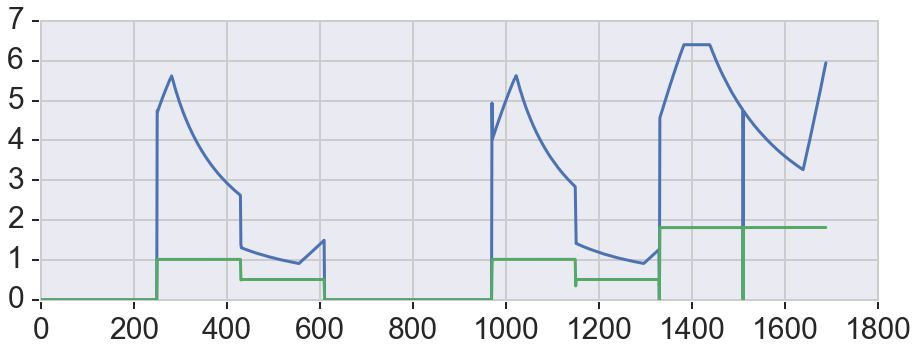

In [33]:
mflat_list = [item for sublist in all_alicat_actual_set_points[5] for item in sublist]
# mfl = []
# for i in range(len(all_alicat_actual_set_points[0])):
#     mflat_list = [item for sublist in all_alicat_actual_set_points[0][i] for item in sublist]
#     mfl.append(mflat_list)
fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
plt.plot((mflat_list), linewidth = 3)

ax1.set_ylim([0, 7])
# ax1.set_xlim([0, (len(p))])
#ax1.set_xticks(np.arange(0, 5401, 1800))
#ax1.set_yticks(np.arange(-180, 225,45))
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)
#ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#box, ticks format
sns.set_style("ticks")
sns.despine()
ax1.tick_params(direction='in', length=8, width=2)
sns.despine(offset=10, trim=False);
ax1.spines['left'].set_linewidth(2)
ax1.spines['bottom'].set_linewidth(2)
ax1.grid(True,linewidth=2)

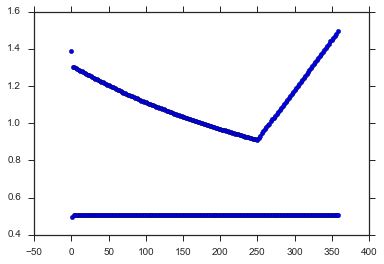

In [34]:
f1 = []
for i in range(len(all_alicat_actual_set_points[5][6])):
    for j in range(len(all_alicat_actual_set_points[5][6][i])):
        #print(all_alicat_actual_set_points[0][6][i][j])
        mf1 = (all_alicat_actual_set_points[5][6][i][j])
        f1.append(mf1)
plt.scatter(np.arange(len(f1)),f1)


In [35]:
print(all_alicat_actual_set_points[0][6])

[[4.2225, 1.9916], [4.2133, 2.0006], [4.2021, 1.9998], [4.1906, 2.0007], [4.1754, 2.0005], [4.1645, 2.0], [4.1537, 1.9998], [4.1422, 2.0], [4.1311, 2.0002], [4.1086, 2.0009], [4.0979, 2.0], [4.0869, 2.0001], [4.0762, 1.9998], [4.0654, 2.0004], [4.0547, 2.0005], [4.0406, 2.001], [4.0301, 2.0009], [4.0197, 2.0002], [4.0092, 2.0009], [3.9986, 2.0005], [3.9889, 2.0012], [3.9748, 2.0009], [3.965, 1.9998], [3.9547, 2.0013], [3.9447, 1.9999], [3.9346, 2.0005], [3.9248, 2.0012], [3.9113, 2.0009], [3.9021, 2.0008], [3.8922, 2.001], [3.8824, 2.001], [3.8732, 2.0007], [3.8633, 2.0004], [3.8537, 2.0009], [3.8406, 2.0005], [3.8445, 2.0007], [3.835, 2.0005], [3.8258, 2.0009], [3.8158, 2.0013], [3.8068, 2.0011], [3.798, 2.0012], [3.7881, 2.0002], [3.7758, 2.0015], [3.7668, 2.0015], [3.7574, 2.0006], [3.7484, 2.0003], [3.7389, 2.0017], [3.7297, 2.0005], [3.7209, 2.0008], [3.7088, 2.0008], [3.6998, 2.0013], [3.6916, 2.0018], [3.6822, 2.0009], [3.6738, 2.0012], [3.6648, 2.0005], [3.6564, 2.0009], [3.644

In [36]:
#exp dependant!
#temp fix
#Because one of the trials is dark and there is no pattern_id
#or gain for that trial:

lp_to_lpvdesert = [0,1,2,3,'NaN',4,5,6,7,8,9,10,11]

all_pat_angles_vd = []
for i in range(len(all_pat_angles)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_pat_angles[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_pat_angles_vd.append(lp_vd)


all_speeds_vd = []
for i in range(len(all_speeds)):
    lp_vd = []
    for j in range(len(lp_to_lpvdesert)):
        try:
            lp = all_speeds[i][lp_to_lpvdesert[j]]
        except:
            lp = 'NaN'
        lp_vd.append(lp)
    all_speeds_vd.append(lp_vd)

print(all_pat_angles)
print(all_pat_angles_vd)

[[-90, 180, 90, 0, 180, 180, 90, 180, 90, 180, 90, 90], [0, 180, 90, -90, 90, 90, 90, 180, 90, 180, 180, 180], [90, 180, -90, 0, 90, 180, 90, 180, 180, 90, 90, 180], [-90, 180, 90, 0, 90, 180, 90, 90, 180, 180, 180, 90], [0, -90, 90, 180, 180, 90, 180, 180, 90, 90, 90, 180], [90, -90, 0, 180, 90, 90, 180, 90, 180, 180, 180, 90], [0, 180, -90, 90, 90, 180, 90, 180, 180, 180, 90, 90], [0, 180, -90, 90, 90, 90, 180, 90, 90, 180, 180, 180], [180, -90, 90, 0, 180, 180, 90, 90, 90, 90, 180, 180]]
[[-90, 180, 90, 0, 'NaN', 180, 180, 90, 180, 90, 180, 90, 90], [0, 180, 90, -90, 'NaN', 90, 90, 90, 180, 90, 180, 180, 180], [90, 180, -90, 0, 'NaN', 90, 180, 90, 180, 180, 90, 90, 180], [-90, 180, 90, 0, 'NaN', 90, 180, 90, 90, 180, 180, 180, 90], [0, -90, 90, 180, 'NaN', 180, 90, 180, 180, 90, 90, 90, 180], [90, -90, 0, 180, 'NaN', 90, 90, 180, 90, 180, 180, 180, 90], [0, 180, -90, 90, 'NaN', 90, 180, 90, 180, 180, 180, 90, 90], [0, 180, -90, 90, 'NaN', 90, 90, 180, 90, 90, 180, 180, 180], [180, -

In [37]:
#get the rolling mean angle (mean heading of the fly)
#during each trial and the pattern_id to know the
#angle at which the fly was moving with respect to the pattern

# all_rmean_headings = []
# for i in range(len(all_start_frames)):
#     rmean_headings_per_file = [ ]
#     for j in range(len(all_start_frames[i])):
#         a = all_init_angle[i][all_start_frames[i][j]]
#         rmean_headings_per_file.append(a)
#     all_rmean_headings.append(rmean_headings_per_file)

# #get the smallest angle between rmean_headings and angle of pattern
# all_ang_dif = []
# for i in range(len(all_rmean_headings)):
#     ang_dif_per_file = []
#     for j in range(len(all_rmean_headings[i])):
#         if all_pat_angles_vd[i][j]=='NaN':
#             ang_dif = 'NaN'
#         else:
#             ang_dif = np.rad2deg(smallestSignedAngleBetween(np.deg2rad(all_rmean_headings[i][j]), 
#                                                  np.deg2rad(all_pat_angles_vd[i][j])))
#         ang_dif_per_file.append(ang_dif)
#     all_ang_dif.append(ang_dif_per_file)

In [38]:
#exp dependant!
#sort the differences of angles of headings and patterns
# for i in range(len(all_ang_dif)):
#     mean_ang_dif = np.mean(np.abs(all_ang_dif[i][5:13]))
#     print(mean_ang_dif)
    
# #did it manually, need to implement
# ang_dif = [0,0,0,180,0,180,0,0,180,180,0,90,180,90,90,180,90,0,0]

# zeroo = [0,1,2,4,6,7,10,17,18]
# fb = [3,5,8,9,12,15]
# ort = [11,13,14,16]

In [39]:
print(str(all_alicat_set_points[0][0]))

0.0


In [40]:
# # #plot and save raw data
# sns.set_style("ticks")
# allangles = all_magnotether_interp_angles

# for i in range(len(datapaths)):
#     # #plot raw normed data
#     fig, axs = plt.subplots(figsize=(30, 80), facecolor='w', edgecolor='k')
#     #fig.tight_layout()
#     fig.suptitle('Experiment '+exp+'\n'+'raw data '+'Fly '+str(i),fontsize = 30, fontweight='bold')
#     fig.subplots_adjust(top=0.94, hspace = .4, bottom=0.05)
    
#     bckclr_labels = ['darkseagreen','darkseagreen', 'darkseagreen','darkseagreen','darkseagreen']
    
#     WF_speed = []
    
#     gs = gridspec.GridSpec(9, 2)
    
#     ######################################################################################################   
    
# ##  #control trials (0-3) and dark (4)
#     ax1 = plt.subplot(gs[0, :])
    
#     a = all_start_frames_m[i][0]
#     b = all_end_frames_m[i][0]
#     c = all_start_frames_m[i][1]
#     d = all_end_frames_m[i][1]
#     e = all_start_frames_m[i][2]
#     f = all_end_frames_m[i][2]
#     g = all_start_frames_m[i][3]
#     h = all_end_frames_m[i][3]
#     j = all_start_frames_m[i][4]
#     k = all_end_frames_m[i][4]
    
#     ang_to_plot = allangles[i][a:k] 
    
#     ax1.plot(reg_t[a:k],ang_to_plot,color = 'k')
    
#     ax1.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][0], all_pat_angles_vd[i][0]), 'green', linewidth= 3)
#     ax1.plot((reg_t[c],reg_t[d]), (all_pat_angles_vd[i][1], all_pat_angles_vd[i][1]), 'green', linewidth= 3)
#     ax1.plot((reg_t[e],reg_t[f]), (all_pat_angles_vd[i][2], all_pat_angles_vd[i][2]), 'green', linewidth= 3)
#     ax1.plot((reg_t[g],reg_t[h]), (all_pat_angles_vd[i][3], all_pat_angles_vd[i][3]), 'green', linewidth= 3)
#     ax1.plot((reg_t[j],reg_t[k]), (all_pat_angles_vd[i][4], all_pat_angles_vd[i][4]), 'green', linewidth= 3)
    
#     #plot format
#     ax1.set_title('VF speed = '+str(all_speeds_vd[i][3])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][3]), fontsize = 30, fontweight='bold')
#     ax1.set_ylim([-200, 200])
#     ax1.set_xlim([reg_t[a], reg_t[k]])
#     ax1.set_xticks(np.arange(reg_t[a], reg_t[h], 60))
#     ax1.set_yticks(np.arange(-180, 225,45))
#     ax1.yaxis.set_tick_params(labelsize=30)
#     ax1.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax1.axvspan(reg_t[j], reg_t[k], facecolor='lightgray', alpha=1)
#     ax1.patch.set_facecolor(bckclr_labels[0])
#     ax1.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax1.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax1.spines['left'].set_linewidth(2)
#     ax1.spines['bottom'].set_linewidth(2)
#     ax1.grid(True,linewidth=2)
    
#     ######################################################################################################
    
# ## #trial 5 
#     ax2 = plt.subplot(gs[1, :])
    
#     a = all_start_frames_m[i][5]
#     b = all_end_frames_m[i][5]
    
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax2.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax2.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][5], all_pat_angles_vd[i][5]), 'green', linewidth= 3)
#     #wind flow
#     ax2.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax2.set_title('VF speed = '+str(all_speeds_vd[i][5])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][5]), fontsize = 30, fontweight='bold')
#     ax2.set_ylim([-200, 200])
#     ax2.set_xlim([reg_t[a], reg_t[b]])
#     ax2.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax2.set_yticks(np.arange(-180, 225,45))
#     ax2.yaxis.set_tick_params(labelsize=30)
#     ax2.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax2.patch.set_facecolor(bckclr_labels[0])
#     ax2.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax2.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax2.spines['left'].set_linewidth(2)
#     ax2.spines['bottom'].set_linewidth(2)
#     ax2.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ## #trial 5 and 6 sun only
#     ax3 = plt.subplot(gs[2, :])
    
#     a = all_start_frames_m[i][6]
#     b = all_end_frames_m[i][6]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax3.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax3.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][6], all_pat_angles_vd[i][6]), 'green', linewidth= 3)
#     #wind flow
#     ax3.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax3.set_title('VF speed = '+str(all_speeds_vd[i][6])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][6]), fontsize = 30, fontweight='bold')
#     ax3.set_ylim([-200, 200])
#     ax3.set_xlim([reg_t[a], reg_t[b]])
#     ax3.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax3.set_yticks(np.arange(-180, 225,45))
#     ax3.yaxis.set_tick_params(labelsize=30)
#     ax3.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax3.patch.set_facecolor(bckclr_labels[1])
#     ax3.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax3.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False);
#     ax3.spines['left'].set_linewidth(2)
#     ax3.spines['bottom'].set_linewidth(2)
#     ax3.grid(True,linewidth=2) 
    
#     ######################################################################################################
    
# ##    #trial 7 and 8 sun only
    
#     ax4 = plt.subplot(gs[3, :])
    
#     a = all_start_frames_m[i][7]
#     b = all_end_frames_m[i][7]

#     ang_to_plot = allangles[i][a:b] 
    
#     ax4.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax4.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][7], all_pat_angles_vd[i][7]), 'green', linewidth= 3)
#     #wind flow
#     ax4.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax4.set_title('VF speed = '+str(all_speeds_vd[i][7])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][7]), fontsize = 30, fontweight='bold')
#     ax4.set_ylim([-200, 200])
#     ax4.set_xlim([reg_t[a], reg_t[b]])
#     ax4.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax4.set_yticks(np.arange(-180, 225,45))
#     ax4.yaxis.set_tick_params(labelsize=30)
#     ax4.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax4.patch.set_facecolor(bckclr_labels[2])
#     ax4.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax4.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax4.spines['left'].set_linewidth(2)
#     ax4.spines['bottom'].set_linewidth(2)
#     ax4.grid(True,linewidth=2)
    
# #     ######################################################################################################
    
# ##    #trial 9
#     ax5 = plt.subplot(gs[4, :])
    
#     a = all_start_frames_m[i][8]
#     b = all_end_frames_m[i][8]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax5.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax5.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][8], all_pat_angles_vd[i][8]), 'green', linewidth= 3)
#     #wind flow
#     ax5.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax5.set_title('VF speed = '+str(all_speeds_vd[i][8])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][8]), fontsize = 30, fontweight='bold')
#     ax5.set_ylim([-200, 200])
#     ax5.set_xlim([reg_t[a], reg_t[b]])
#     ax5.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax5.set_yticks(np.arange(-180, 225,45))
#     ax5.yaxis.set_tick_params(labelsize=30)
#     ax5.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax5.patch.set_facecolor(bckclr_labels[3])
#     ax5.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax5.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax5.spines['left'].set_linewidth(2)
#     ax5.spines['bottom'].set_linewidth(2)
#     ax5.grid(True,linewidth=2)
    
# #   ######################################################################################################

# ##    #trial 9
#     ax6 = plt.subplot(gs[5, :])
    
#     a = all_start_frames_m[i][9]
#     b = all_end_frames_m[i][9]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax6.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax6.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][9], all_pat_angles_vd[i][9]), 'green', linewidth= 3)
#     #wind flow
#     ax6.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax6.set_title('VF speed = '+str(all_speeds_vd[i][9])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][9]), fontsize = 30, fontweight='bold')
#     ax6.set_ylim([-200, 200])
#     ax6.set_xlim([reg_t[a], reg_t[b]])
#     ax6.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax6.set_yticks(np.arange(-180, 225,45))
#     ax6.yaxis.set_tick_params(labelsize=30)
#     ax6.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax6.patch.set_facecolor(bckclr_labels[3])
#     ax6.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax6.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax6.spines['left'].set_linewidth(2)
#     ax6.spines['bottom'].set_linewidth(2)
#     ax6.grid(True,linewidth=2)
    
# #   ######################################################################################################

# ##    #trial 9
#     ax7 = plt.subplot(gs[6, :])
    
#     a = all_start_frames_m[i][10]
#     b = all_end_frames_m[i][10]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax7.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax7.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][10], all_pat_angles_vd[i][10]), 'green', linewidth= 3)
#     #wind flow
#     ax7.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax7.set_title('VF speed = '+str(all_speeds_vd[i][10])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][10]), fontsize = 30, fontweight='bold')
#     ax7.set_ylim([-200, 200])
#     ax7.set_xlim([reg_t[a], reg_t[b]])
#     ax7.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax7.set_yticks(np.arange(-180, 225,45))
#     ax7.yaxis.set_tick_params(labelsize=30)
#     ax7.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax7.patch.set_facecolor(bckclr_labels[3])
#     ax7.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax7.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax7.spines['left'].set_linewidth(2)
#     ax7.spines['bottom'].set_linewidth(2)
#     ax7.grid(True,linewidth=2)
    
# #   ######################################################################################################
# ##    #trial 10
#     ax8 = plt.subplot(gs[7, :])
    
#     a = all_start_frames_m[i][11]
#     b = all_end_frames_m[i][11]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax8.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax8.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][11], all_pat_angles_vd[i][11]), 'green', linewidth= 3)
#     #wind flow
#     ax8.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax8.set_title('VF speed = '+str(all_speeds_vd[i][11])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][11]), fontsize = 30, fontweight='bold')
#     ax8.set_ylim([-200, 200])
#     ax8.set_xlim([reg_t[a], reg_t[b]])
#     ax8.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax8.set_yticks(np.arange(-180, 225,45))
#     ax8.yaxis.set_tick_params(labelsize=30)
#     ax8.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax8.patch.set_facecolor(bckclr_labels[3])
#     ax8.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax8.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax8.spines['left'].set_linewidth(2)
#     ax8.spines['bottom'].set_linewidth(2)
#     ax8.grid(True,linewidth=2)
    
# #   ######################################################################################################
# ##    #trial 10
#     ax9 = plt.subplot(gs[8, :])
    
#     a = all_start_frames_m[i][12]
#     b = all_end_frames_m[i][12]
    
#     ang_to_plot = allangles[i][a:b] 
    
#     ax9.plot(reg_t[a:b],ang_to_plot,color = 'k')
#     #optic flow
#     ax9.plot((reg_t[a],reg_t[b]), (all_pat_angles_vd[i][12], all_pat_angles_vd[i][12]), 'green', linewidth= 3)
#     #wind flow
#     ax9.plot((reg_t[a],reg_t[b]), (0, 0), 'blue', linewidth= 3)
    
#     #plot format
#     ax9.set_title('VF speed = '+str(all_speeds_vd[i][12])+ ' px/s'+'\n WF set point = '+str(
#         all_alicat_set_points[i][12]), fontsize = 30, fontweight='bold')
#     ax9.set_ylim([-200, 200])
#     ax9.set_xlim([reg_t[a], reg_t[b]])
#     ax9.set_xticks(np.arange(reg_t[a], reg_t[b], 59))
#     ax9.set_yticks(np.arange(-180, 225,45))
#     ax9.yaxis.set_tick_params(labelsize=30)
#     ax9.xaxis.set_tick_params(labelsize=30)
#     #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#     ax9.patch.set_facecolor(bckclr_labels[3])
#     ax9.patch.set_alpha(0.7)
#     #box, ticks format
#     sns.set_style("ticks")
#     sns.despine()
#     ax9.tick_params(direction='in', length=8, width=2)
#     sns.despine(offset=10, trim=False)
#     ax9.spines['left'].set_linewidth(2)
#     ax9.spines['bottom'].set_linewidth(2)
#     ax9.grid(True,linewidth=2)
    
# # #   ######################################################################################################

#     savefigdir = '/Users/fponce/Documents/vdesert/VD_120719/raw_data/'
#     fig.savefig(savefigdir+exp+'_rawdata_'+'Fly_'+str(i)+'.pdf')  #bbox_inches='tight'

In [41]:
#vf 
allangles = copy.deepcopy(all_magnotether_interp_angles)
allangles_vf = copy.deepcopy(all_magnotether_interp_angles)

all_pat_angles_vda = []
for i in all_pat_angles_vd:
    pat_angles_vda = [0 if x=='NaN' else x for x in i]
    all_pat_angles_vda.append(pat_angles_vda)
    
for i in range(len(allangles_vf)):
    for j in range(len(all_start_frames_m[i])):
        allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]] = get_smallestSignedAngleBetween(\
        allangles[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]], all_pat_angles_vda[i][j])

In [42]:
#get circular means in vf reference frame
all_circmeans_vf = []
all_circmeans_deg_vf = []
all_circvars_vf = []
for i in range(len(allangles_vf)):
    circmeans_vf = []
    circmeans_deg_vf = []
    circvars_vf = []
    for j in range(len(all_start_frames_m[i])):
        angles_rad_vf = np.deg2rad(allangles_vf[i][all_start_frames_m[i][j]:all_end_frames_m[i][j]])
        circmeann_vf = circmean(angles_rad_vf)
        circvarr_vf = circvar(angles_rad_vf)
        circmeann_deg_vf = np.rad2deg(circmeann_vf)
        
        circmeans_vf.append((circmeann_vf))
        circmeans_deg_vf.append((circmeann_deg_vf))
        circvars_vf.append((circvarr_vf))
        
    all_circmeans_deg_vf.append(circmeans_deg_vf)
    all_circmeans_vf.append(circmeans_vf)
    all_circvars_vf.append(circvars_vf)

In [43]:
#exp dependant - sort trials depending on WF
#180 deg, wf: 0, 0.5, 1.0, 2.0
#90 deg, wf: 0, 0.5, 1.0, 2.0

# print(all_pat_angles_vd[0])
# print(all_alicat_set_points[0])

trials_to_be_sorted=[5,6,7,8,9,10,11,12]

#exp dependant
#sorted like this:
#90 deg, wf: 0, 0.5, 1.0, 2.0
#180 deg, wf: 0, 0.5, 1.0, 2.0

all_idxs_sorted = []
for i in range(len(all_pat_angles_vd)):
    all_pat_angles_vd_s = all_pat_angles_vd[i][5:]
    all_alicat_set_points_s = all_alicat_set_points[i][5:]

    sorted_trials1 = []
    sorted_trials2 = []
    sorted_trials3 = []
    sorted_trials4 = []
    sorted_trials5 = []
    sorted_trials6 = []
    sorted_trials7 = []
    sorted_trials8 = []
    
    for j in range(len(all_pat_angles_vd_s)):
        if all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 0.0:
            sorted_trials1.append(j+5)

        elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 0.5:  
            sorted_trials2.append(j+5)

        elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] == 1.0:  
            sorted_trials3.append(j+5)

        elif all_pat_angles_vd_s[j] == 90 and all_alicat_set_points_s[j] >= 1.3:  
            sorted_trials4.append(j+5)

        elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 0.0:
            sorted_trials5.append(j+5)

        elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 0.5:  
            sorted_trials6.append(j+5)

        elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] == 1.0:  
            sorted_trials7.append(j+5)

        elif all_pat_angles_vd_s[j] == 180 and all_alicat_set_points_s[j] >= 1.3:  
            sorted_trials8.append(j+5)
        
        #first list is the control 1 min trials at start of exp
        sorted_trials = ([0,1,2,3],sorted_trials1,sorted_trials2,sorted_trials3,sorted_trials4,
                            sorted_trials5,sorted_trials6,sorted_trials7,sorted_trials8)
        
        sorted_trials_flat_list = [item for sublist in sorted_trials for item in sublist]
        
    all_idxs_sorted.append(sorted_trials_flat_list)

print(all_idxs_sorted)

[[0, 1, 2, 3, 7, 9, 12, 11, 5, 10, 8, 6], [0, 1, 2, 3, 7, 9, 5, 6, 12, 8, 11, 10], [0, 1, 2, 3, 10, 7, 5, 11, 6, 12, 9, 8], [0, 1, 2, 3, 8, 7, 5, 12, 9, 10, 6, 11], [0, 1, 2, 3, 6, 11, 10, 9, 5, 12, 8, 7], [0, 1, 2, 3, 8, 6, 5, 12, 7, 10, 9, 11], [0, 1, 2, 3, 5, 7, 11, 12, 9, 10, 6, 8], [0, 1, 2, 3, 8, 9, 6, 5, 12, 11, 7, 10], [0, 1, 2, 3, 9, 10, 7, 8, 12, 11, 6, 5]]


In [44]:
#sorting trials in terms of speed
# all_speeds_vd_sorted = copy.deepcopy(all_speeds_vd)

# all_speeds_vd_s = []
# for i in range(len(all_speeds_vd_sorted)):
#     s = all_speeds_vd_sorted[i][5:]
#     all_speeds_vd_s.append(s)
# print(all_speeds_vd_s)
# trials_to_be_sorted=[5,6,7,8,9,10,11]

# all_idxs_sorted = []
# for i in range(len(all_speeds_vd_s)):
#     idxs_s = np.argsort(np.array(all_speeds_vd_s[i]))
#     idxs_sorted = idxs_s+5
#     all_idxs_sorted.append(idxs_sorted)

In [50]:
print(all_pat_angles_vda)

[[-90, 180, 90, 0, 0, 180, 180, 90, 180, 90, 180, 90, 90], [0, 180, 90, -90, 0, 90, 90, 90, 180, 90, 180, 180, 180], [90, 180, -90, 0, 0, 90, 180, 90, 180, 180, 90, 90, 180], [-90, 180, 90, 0, 0, 90, 180, 90, 90, 180, 180, 180, 90], [0, -90, 90, 180, 0, 180, 90, 180, 180, 90, 90, 90, 180], [90, -90, 0, 180, 0, 90, 90, 180, 90, 180, 180, 180, 90], [0, 180, -90, 90, 0, 90, 180, 90, 180, 180, 180, 90, 90], [0, 180, -90, 90, 0, 90, 90, 180, 90, 90, 180, 180, 180], [180, -90, 90, 0, 0, 180, 180, 90, 90, 90, 90, 180, 180]]


In [46]:
print((all_idxs_sorted[0]))
print((all_circmeans_vf[0]))

[0, 1, 2, 3, 7, 9, 12, 11, 5, 10, 8, 6]
[0.09604433073419363, 0.40242776169015987, -1.288449804577576, -0.3287647125661414, -0.24705710209866755, -1.3131614355591121, -3.031448455312242, -1.364122612858096, -1.7028217221258777, -1.4098220081256199, -1.4652163280458241, -1.2316994112001092, -1.4877518304098778]


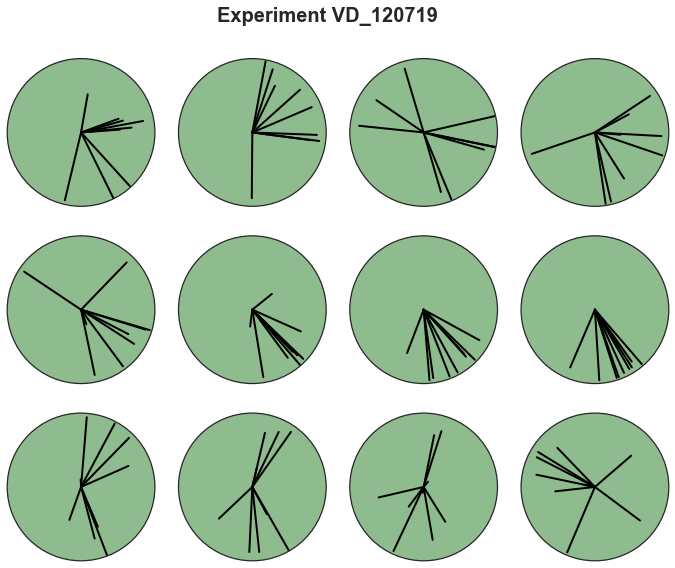

In [49]:
# # circular means plot

fig, axs = plt.subplots(3,4, figsize=(12, 9), facecolor='w', edgecolor='k', subplot_kw=dict(polar=True))
fig.subplots_adjust(hspace = .2, wspace = .1)
fig.suptitle('Experiment '+exp,fontsize = 20, fontweight='bold')

axs = axs.ravel()
p_labels = ['0.0', '1.0', '2.0', '4.0', '8.0', '16.0', '30.0']
bckclr_labels = ['darkseagreen']

axisorder = [0,1,2,3,4,5,6,7,8,9,10,11]

for j in range(len(all_idxs_sorted[0])):
    for i in range(len(all_circmeans_vf)):

        cms = all_circmeans_vf[i][all_idxs_sorted[i][j]]
        cvs = all_circvars_vf[i][all_idxs_sorted[i][j]]

        axs[axisorder[j]].plot((0, cms), ( 0, cvs), alpha = 1, color = 'k', linewidth =2)
        a=np.deg2rad(all_pat_angles_vd[i][all_idxs_sorted[i][j]])

        #axs[axisorder[j]].plot((0, 0), ( 0, 1), alpha = 0.9, color = 'b', linewidth =2)
        #axs[axisorder[j]].plot((0, a), ( 0, 1), alpha = 0.9, color = 'r', linewidth =2)
        axs[axisorder[j]].grid(False)
        axs[axisorder[j]].set_yticks([])
        axs[axisorder[j]].set_xticks([])
        axs[axisorder[j]].spines['polar'].set_visible(True)
        axs[axisorder[j]].set_rlim(0,1) 
        #axs[axisorder[j]].set_title(p_labels[j],fontsize = 15, fontweight='bold')
        axs[axisorder[j]].xaxis.set_tick_params(labelsize=15, pad=10)
        axs[axisorder[j]].patch.set_facecolor(bckclr_labels[0])

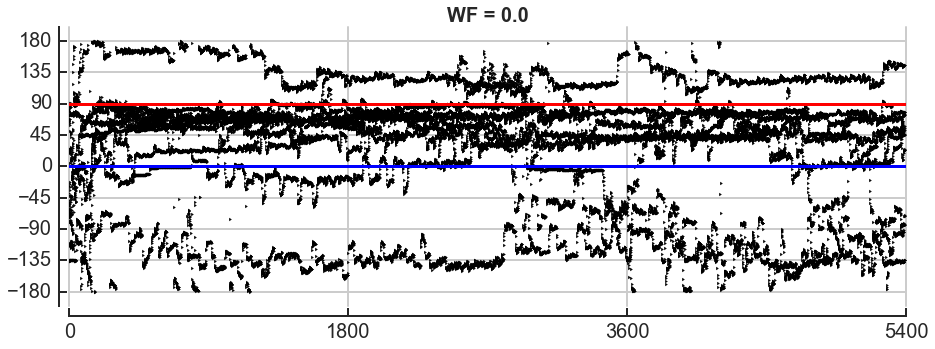

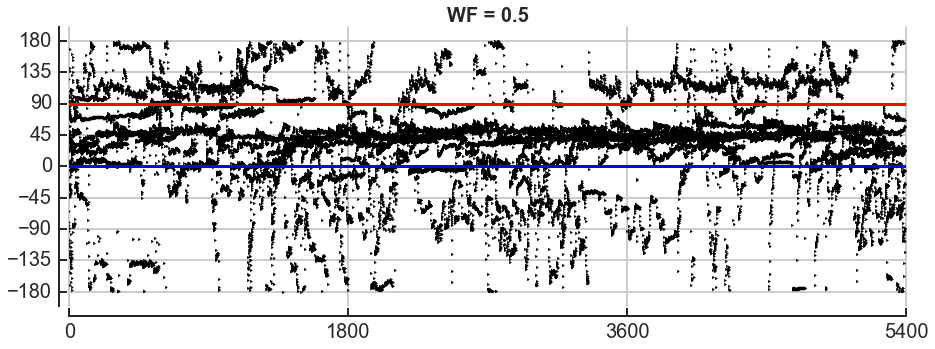

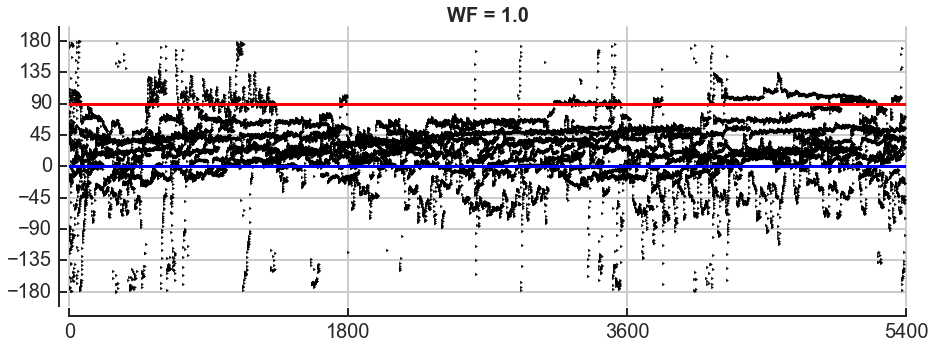

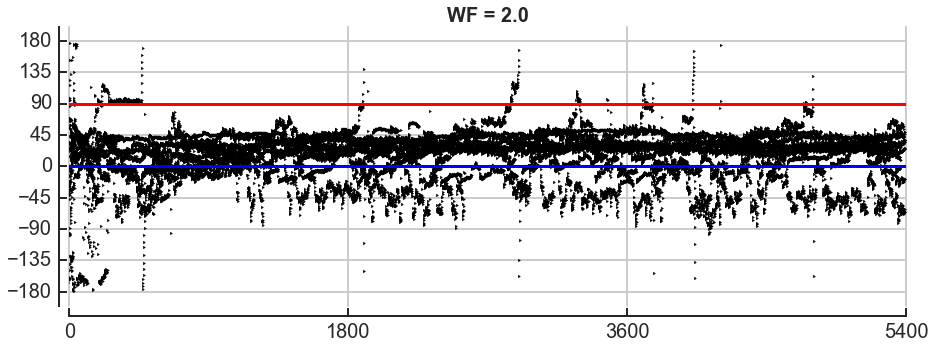

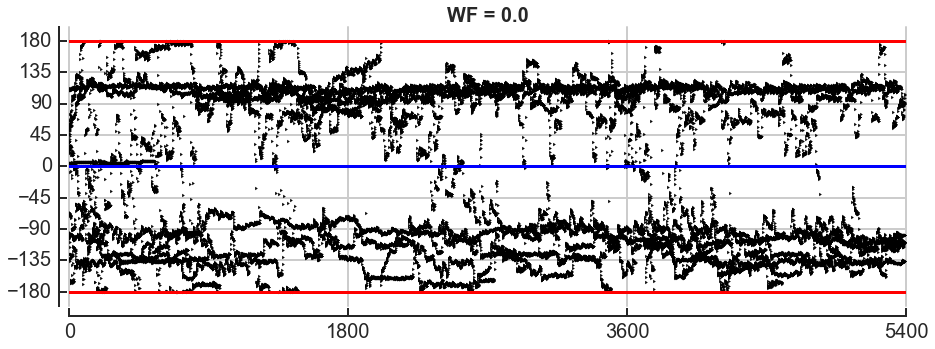

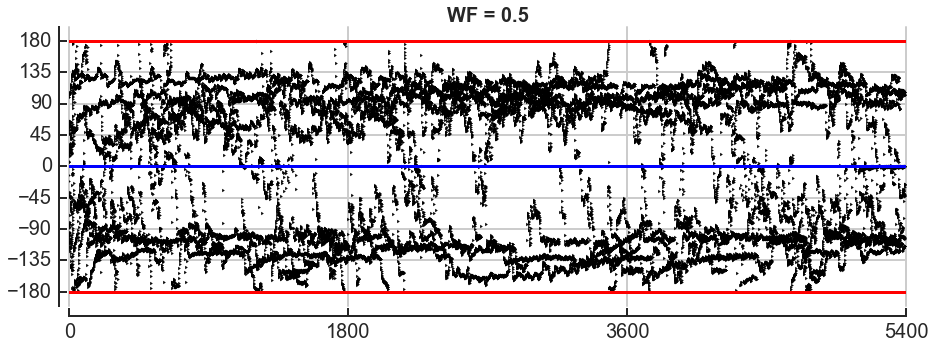

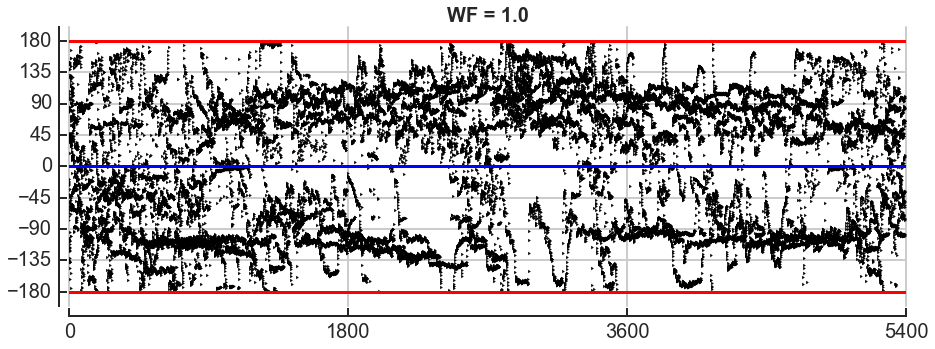

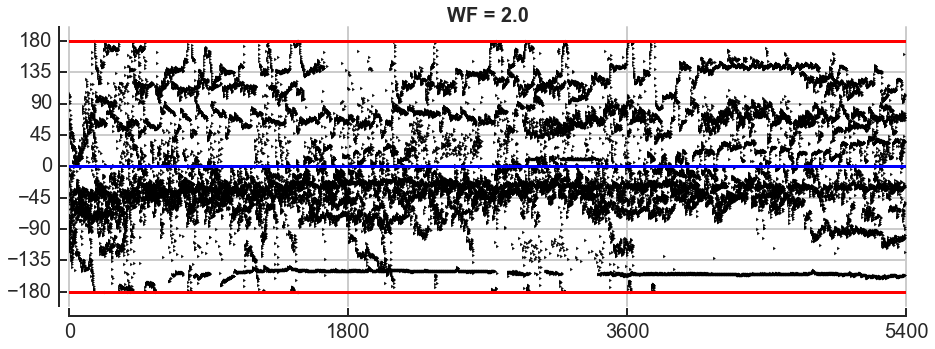

In [95]:
p_labels = ['0.0', '0.5', '1.0', '2.0','0.0', '0.5', '1.0', '2.0','0.0', '0.5', '1.0', '2.0']


for j in range(len(all_idxs_sorted[0])):

    if j>=4:
        
        fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
        for i in range(len(allangles)): 
            p = allangles[i][all_start_frames_m[i][all_idxs_sorted[i][j]]:all_end_frames_m[i][all_idxs_sorted[i][j]]]
            plt.scatter(np.arange(len(p)),p,s=10,color='k', marker = 5)#,alpha=0.1)
            ax1.plot((0,5400), (0, 0), 'blue', linewidth= 3)
            #ax1.set_title(p_labels[j],fontsize = 15, fontweight='bold')
            #plot format
            #ax1.set_title('speed = '+ p_labels[j]+' pixels/s',fontsize = 20, fontweight='bold')
            ax1.set_ylim([-200, 200])
            ax1.set_xlim([0, (len(p))])
            ax1.set_xticks(np.arange(0, 5401, 1800))
            ax1.set_yticks(np.arange(-180, 225,45))
            ax1.yaxis.set_tick_params(labelsize=20)
            ax1.xaxis.set_tick_params(labelsize=20)
            #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
            #box, ticks format
            sns.set_style("ticks")
            sns.despine()
            ax1.tick_params(direction='in', length=8, width=2)
            sns.despine(offset=10, trim=False);
            ax1.spines['left'].set_linewidth(2)
            ax1.spines['bottom'].set_linewidth(2)
            ax1.grid(True,linewidth=2)
            
            if j in [4,5,6,7]:
                ax1.plot((0,5400), (90, 90), 'red', linewidth= 3)
                ax1.set_title('WF = '+ str(p_labels[j]),fontsize = 20, fontweight='bold')

            elif j in [8,9,10,11]:
                ax1.plot((0,5400), (180, 180), 'red', linewidth= 3)
                ax1.plot((0,5400), (-180, -180), 'red', linewidth= 3)
                ax1.set_title('WF = '+ str(p_labels[j]),fontsize = 20, fontweight='bold')